In [1]:
# Execute this first 
#
#  * trigger notebook styling
#  * check if notebook had been modified since its distribution
# 
# Note: executing any cells before this modifies the notebook.
# 
%run src/init_notebooks.py
hide_toggle()
check_notebook()

/Users/ethan/md-intro-tutorial/md-intro-tutorial-main/src/init_notebooks.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Notebook has been modified


# Molecular dynamics simulation of a small protein using GROMACS 

    authors  : Alessandra Villa (based on a Justin Lemkuhl tutorial see http://www.mdtutorials.com or Living J. Comp. Mol. Sci. 2018, 1, 5068).    
    goal     : learn step-by-step how to run a molecular dynamics simulation of a small protein using GROMACS 
    time     : 90 minutes
    software : GROMACS 2022, python modules: numpy, matplotlib, re, nglviewer, md_traj, panda. 
    optional software: visualization software [VMD](https://www.ks.uiuc.edu/Research/vmd), Xmgrace plotting tool
    tutorial source: tutorials.gromacs.org
    version  : release

# Preparations to run this notebook

In [2]:
# Change to the data directory
# Note that executing this command twice will result in an error you can ignore
%cd data

/Users/ethan/md-intro-tutorial/md-intro-tutorial-main/data


# Obtaining the input for a simulation

The starting point for each simulation is a molecular structure file. For this tutorial, we will utilize Factor Xa, a protein playing critical role in the formation of blood clots. The 3D structure is available from the RCSB website, https://www.rcsb.org/ with PDB code 1FJS. You can find the PDB file for the crystal structure in "input" directory as "1fjs.pdb".

Now we visualize the structure

In [3]:
import nglview as ng
view = ng.show_structure_file("input/1fjs.pdb")
view
# click and drag to rotate, zoom with your mouseweel 
# for more infor on this viewer have a look at https://github.com/nglviewer/nglview

NGLWidget()

In alternative, you can use VMD to visualize the structure on your local machine. To run VMD from within this notebook, remove the comment character (#) in the following cell and VMD should pop up:
 **`close the VMD window after you are done looking at the protein to continue with this notebook`**

In [4]:
#!vmd input/1fjs.pdb

## Cleaning the input structure

Once you've had a look at the molecule, you are going to want to strip out all the atoms that do not belong to the protein (e.i crystal waters, ligands, etc). To delete those atoms (labelled "HETATM" in the PDB file) and eventually their connectivity, either use a plain text editor like vi, emacs (Linux/Mac), or Notepad (Windows). Do not use word processing software! Alternatively, you can use grep to delete these lines very easily:

In [5]:
!grep -v HETATM input/1fjs.pdb > 1fjs_protein_tmp.pdb
!grep -v CONECT 1fjs_protein_tmp.pdb > 1fjs_protein.pdb

View the cleaned structure

In [6]:
import nglview as ng
view = ng.show_structure_file("1fjs_protein.pdb")
view
# click and drag to rotate, zoom with your mouseweel 
# for more infor on this viewer have a look at https://github.com/nglviewer/nglview

NGLWidget()

In alternative, you can use VMD to visualize the structure on your local machine. To run VMD from within this notebook, remove the comment character (#) in the following cell and VMD should pop up:

In [7]:
#!vmd 1fjs_protein.pdb

Note *Such a procedure is not universally appropriate (e.g., the case of a tightly bound ligand or otherwise functional active-site water molecule).*

Always check your .pdb file for entries listed under the comment MISSING, as these entries indicate either atoms or whole residues that are not present in the crystal structure. Terminal regions may be absent, and may not present a problem for dynamics.

In [8]:
!grep MISSING input/1fjs.pdb

## Generating a topology

Now we have verified that all the necessary atoms are present and the PDB file contains only protein atoms, and is ready to be input into GROMACS (see <a href=http://manual.gromacs.org/current/index.html> GROMACS documentation </a>). 
The first GROMACS tool, we use, is pdb2gmx. The purpose of pdb2gmx is to generate three files:

* The topology for the molecule.
* A position restraint file.
* A post-processed structure file. 

The topology (topol.top by default) contains all the information necessary to define the molecule within a simulation. This information includes nonbonded parameters (atom types and charges) as well as bonded parameters (bonds, angles, dihedrals and atom connectivity). We will take a more detailed look at the topology once it has been generated.

Note *Incomplete internal sequences or any amino acid residues that have missing atoms will cause pdb2gmx to fail. These missing atoms/residues must be modeled in using other software packages. Also note that pdb2gmx is not magic. It cannot generate topologies for arbitrary molecules, just the residues defined by the force field (in the *.rtp files - generally proteins, nucleic acids, and a very finite amount of cofactors, like NAD(H) and ATP).*

Execute pdb2gmx by issuing the following command:

In [9]:
!gmx pdb2gmx -f 1fjs_protein.pdb -o 1fjs_processed.gro -water tip3p -ff "charmm27"

                :-) GROMACS - gmx pdb2gmx, 2022-conda_forge (-:

Executable:   /Users/ethan/anaconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/ethan/anaconda3/envs/md-intro-tutorial
Working dir:  /Users/ethan/md-intro-tutorial/md-intro-tutorial-main/data
Command line:
  gmx pdb2gmx -f 1fjs_protein.pdb -o 1fjs_processed.gro -water tip3p -ff charmm27

Using the Charmm27 force field in directory charmm27.ff

going to rename charmm27.ff/aminoacids.r2b
Opening force field file /Users/ethan/anaconda3/envs/md-intro-tutorial/share/gromacs/top/charmm27.ff/aminoacids.r2b

going to rename charmm27.ff/rna.r2b
Opening force field file /Users/ethan/anaconda3/envs/md-intro-tutorial/share/gromacs/top/charmm27.ff/rna.r2b
Reading 1fjs_protein.pdb...
Read 'COAGULATION FACTOR XA; COAGULATION FACTOR XA', 2236 atoms

Analyzing pdb file
Splitting chemical chains based on TER records or chain id changing.

There are 2 chains and 0 blocks of water and 286 residues with 2236 atoms

  chain  


Including chain 1 in system: 3673 atoms 234 residues

Including chain 2 in system: 744 atoms 52 residues

Now there are 4417 atoms and 286 residues

Total mass in system 31993.352 a.m.u.

Total charge in system -2.000 e

Writing coordinate file...

Back Off! I just backed up 1fjs_processed.gro to ./#1fjs_processed.gro.1#

		--------- PLEASE NOTE ------------

You have successfully generated a topology from: 1fjs_protein.pdb.

The Charmm27 force field and the tip3p water model are used.

		--------- ETON ESAELP ------------

GROMACS reminds you: "All I Ever Wanted Was Your Life" (Red Hot Chili Peppers)



Here, we made an important decision for the course of the simualtion in choosing the CHARMM27 all-atom force field. The force field will contain the information that will be written to the topology. This is a very important choice! You should always read thoroughly about each force field and decide which is most applicable to your situation. Other choices are given, when running pdb2gmx without the -ff flag

    Select the Force Field:
    From '/usr/local/gromacs/share/gromacs/top':
     1: AMBER03 protein, nucleic AMBER94 (Duan et al., J. Comp. Chem. 24, 1999-2012, 2003)
     2: AMBER94 force field (Cornell et al., JACS 117, 5179-5197, 1995)
     3: AMBER96 protein, nucleic AMBER94 (Kollman et al., Acc. Chem. Res. 29, 461-469, 1996)
     4: AMBER99 protein, nucleic AMBER94 (Wang et al., J. Comp. Chem. 21, 1049-1074, 2000)
     5: AMBER99SB protein, nucleic AMBER94 (Hornak et al., Proteins 65, 712-725, 2006)
     6: AMBER99SB-ILDN protein, nucleic AMBER94 (Lindorff-Larsen et al., Proteins 78, 1950-58, 2010)
     7: AMBERGS force field (Garcia & Sanbonmatsu, PNAS 99, 2782-2787, 2002)
     8: CHARMM27 all-atom force field (CHARM22 plus CMAP for proteins)
     9: GROMOS96 43a1 force field
    10: GROMOS96 43a2 force field (improved alkane dihedrals)
    11: GROMOS96 45a3 force field (Schuler JCC 2001 22 1205)
    12: GROMOS96 53a5 force field (JCC 2004 vol 25 pag 1656)
    13: GROMOS96 53a6 force field (JCC 2004 vol 25 pag 1656)
    14: GROMOS96 54a7 force field (Eur. Biophys. J. (2011), 40,, 843-856, DOI: 10.1007/s00249-011-0700-9)
    15: OPLS-AA/L all-atom force field (2001 aminoacid dihedrals)


There are many other options that can be passed to pdb2gmx (see http://manual.gromacs.org/documentation/current/onlinehelp/gmx-pdb2gmx.html). Some commonly used ones are listed here:

| Option | Effect |
|--------|--------
|-water  | Water model to use: none, spc, spce, tip3p, tip4p, tip5p, tips3p.|
|-ignh   | Ignore H atoms in the PDB file; especially useful for NMR structures. Otherwise, if H atoms are present, they must be in the named exactly how the force fields in GROMACS expect them to be. Different conventions exist, so dealing with H atoms can occasionally be a headache! If you need to preserve the initial H coordinates, but renaming is required, then the Linux sed command is your friend.|
|-ter    | Interactively assign charge states for N- and C-termini.|
|-inter  | Interactively assign charge states for Glu, Asp, Lys, Arg, and His; choose which Cys are involved in disulfide bonds.|

## A peek at the generated files

In [10]:
!ls

#1fjs_processed.gro.1#        1fjs_protein_tmp.pdb
#posre_Protein_chain_A.itp.1# input
#posre_Protein_chain_L.itp.1# posre_Protein_chain_A.itp
#topol.top.1#                 posre_Protein_chain_L.itp
#topol_Protein_chain_A.itp.1# reference
#topol_Protein_chain_L.itp.1# topol.top
1fjs_newbox.gro               topol_Protein_chain_A.itp
1fjs_processed.gro            topol_Protein_chain_L.itp
1fjs_protein.pdb


You have now generated three new files: 1fjs_processed.gro, topol.top, topol_Protein_chain_X.itp and posre_Protein_chain_X.itp. 1fjs_processed.gro is a GROMACS-formatted structure file that contains all the atoms defined within the force field (i.e., H atoms have been added to the amino acids in the protein). The topol.top file is the system topology (more on this in a minute). The posre files contain information used to restrain the positions of heavy atoms (more on this later).

One final note: many users assume that a .gro file is mandatory. This is not true. GROMACS can handle many different file formats, with .gro simply being the default for commands that write coordinate files. It is a very compact format, but it has limited precision. If you prefer to use, for instance, PDB format, all you need to do is to specify an appropriate file name with .pdb extension as your output. The purpose of pdb2gmx is to produce a force field-compliant topology; the output structure is largely a side effect of this purpose and is intended for user convenience. The format can be just about anything you like (see http://manual.gromacs.org/documentation/current/reference-manual/file-formats.html for different formats).

# Understanding molecule "topologies"

Let's look at what is in the output topology (topol.top). Again, using a plain text editor, inspect its contents. After several comment lines (preceded by `;`), you will find the following:

In [11]:
!cat topol.top

;
;	File 'topol.top' was generated
;	By user: ethan (501)
;	On host: Ethans-MBP-4
;	At date: Wed Jun 22 09:43:23 2022
;
;	This is a standalone topology file
;
;	Created by:
;	               :-) GROMACS - gmx pdb2gmx, 2022-conda_forge (-:
;	
;	Executable:   /Users/ethan/anaconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
;	Data prefix:  /Users/ethan/anaconda3/envs/md-intro-tutorial
;	Working dir:  /Users/ethan/md-intro-tutorial/md-intro-tutorial-main/data
;	Command line:
;	  gmx pdb2gmx -f 1fjs_protein.pdb -o 1fjs_processed.gro -water tip3p -ff charmm27
;	Force field was read from the standard GROMACS share directory.
;

; Include forcefield parameters
#include "charmm27.ff/forcefield.itp"

; Include chain topologies
#include "topol_Protein_chain_A.itp"
#include "topol_Protein_chain_L.itp"

; Include water topology
#include "charmm27.ff/tip3p.itp"

#ifdef POSRES_WATER
; Position restraint for each water oxygen
[ position_restraints ]
;  i funct       fcx        fcy        fcz
   1    1   

The first line calls the parameters within the choosen force field. It is at the beginning of the file, indicating that all subsequent parameters are derived from this force field.  Then next important line is [ moleculetype ], that you find in  

In [12]:
!grep "moleculetype" -A 3 topol_Protein_chain_A.itp

[ moleculetype ]
; Name            nrexcl
Protein_chain_A     3



and

In [13]:
!grep "moleculetype" -A 3 topol_Protein_chain_L.itp

[ moleculetype ]
; Name            nrexcl
Protein_chain_L     3



The name "Protein_chain_A" defines the molecule name, based on the fact that the protein was labeled as chain A in the PDB file. There are 3 exclusions for bonded neighbors. More information on exclusions can be found in the <a href=http://manual.gromacs.org/current/reference-manual/topologies.html>GROMACS manual</a>.

## Atoms in a topology

The next section defines the [ atoms ] in the protein. The information is presented as columns:

In [14]:
! grep "atoms" -A 4 topol_Protein_chain_A.itp

[ atoms ]
;   nr       type  resnr residue  atom   cgnr     charge       mass  typeB    chargeB      massB
; residue  16 ILE rtp ILE  q +1.0
     1        NH3     16    ILE      N      1       -0.3     14.007
     2         HC     16    ILE     H1      2       0.33      1.008


The interpretation of this information is as follows:

|Field  |  description |
|--|--
|nr|Atom number
|type| Atom type
|resnr|Amino acid residue number
|residue| The amino acid residue name- Note that this may be different from .rtp entry. 
|atom| Atom name
|cgnr| Charge group number - Not used anymore 
|charge| Self-explanatory - The "qtot" descriptor is a running total of the charge on the molecule
|mass| Also self-explanatory
|typeB, chargeB, massB| Used for free energy perturbation (not discussed here) 

## Bonds and other interactions

Subsequent sections include [ bonds ], [ pairs ], [ angles ], and [ dihedrals ]. Some of these sections are self-explanatory (bonds, angles, and dihedrals). These interactions are found [here](http://manual.gromacs.org/current/reference-manual/functions.html) and special 1-4 interactions are included under [pairs](http://manual.gromacs.org/current/reference-manual/functions/interaction-methods.html#exclusions-and-1-4-interactions). For format associated to function types [see topology file table](http://manual.gromacs.org/documentation/2020-beta1/reference-manual/topologies/topology-file-formats.html) in GROMACS manual.

Below we look for these interactions in topolology file. As example we start with chain A. Bonded interactions

In [15]:
!grep "bonds" -A 2 topol_Protein_chain_A.itp

[ bonds ]
;  ai    aj funct            c0            c1            c2            c3
    1     2     1 


Pair interactions

In [16]:
!grep "pairs" -A 2  topol_Protein_chain_A.itp

[ pairs ]
;  ai    aj funct            c0            c1            c2            c3
    1     8     1 


Angle interactions

In [17]:
!grep "angles" -A 2 topol_Protein_chain_A.itp

[ angles ]
;  ai    aj    ak funct            c0            c1            c2            c3
    2     1     3     5 


Dihedral interactions

In [18]:
!grep "dihedrals" -A 2 topol_Protein_chain_A.itp

[ dihedrals ]
;  ai    aj    ak    al funct            c0            c1            c2            c3            c4            c5
    2     1     5     6     9 
--
[ dihedrals ]
;  ai    aj    ak    al funct            c0            c1            c2            c3
   20     5    22    21     2 


## Water and position restraints

The remainder of the file involves including a few other useful/necessary topologies, starting with position restraints. The "posre.itp" file was generated by pdb2gmx; it defines a force constant used to keep atoms in place during equilibration (more on this later).

In [19]:
!grep "posre" topol*.itp

topol_Protein_chain_A.itp:#include "posre_Protein_chain_A.itp"
topol_Protein_chain_L.itp:#include "posre_Protein_chain_L.itp"


In [20]:
!cat posre_Protein_chain_A.itp

; In this topology include file, you will find position restraint
; entries for all the heavy atoms in your original pdb file.
; This means that all the protons which were added by pdb2gmx are
; not restrained.

[ position_restraints ]
; atom  type      fx      fy      fz
     1     1  1000  1000  1000
     5     1  1000  1000  1000
     7     1  1000  1000  1000
     9     1  1000  1000  1000
    13     1  1000  1000  1000
    16     1  1000  1000  1000
    20     1  1000  1000  1000
    21     1  1000  1000  1000
    22     1  1000  1000  1000
    24     1  1000  1000  1000
    26     1  1000  1000  1000
    28     1  1000  1000  1000
    32     1  1000  1000  1000
    36     1  1000  1000  1000
    37     1  1000  1000  1000
    38     1  1000  1000  1000
    40     1  1000  1000  1000
    43     1  1000  1000  1000
    44     1  1000  1000  1000
    45     1  1000  1000  1000
    47     1  1000  1000  1000
    50     1  1000  1000  1000
    51     1  1000  1000  1000
    52     1  

Here ends the "Protein_chain_A" moleculetype definition. Then the "Protein_chain_L" moleculetype definition starts. The remainder of the topology file is dedicated to defining other molecules and providing system-level descriptions. The next moleculetype (by default) is the solvent, in this case TIP3P water. Other typical choices for water include SPC, SPC/E, and TIP4P. We chose this by passing "-water tip3p" to pdb2gmx. For an excellent summary of the many different water models, click [here](http://www1.lsbu.ac.uk/water/water_models.html) , but be aware that not all of these models are present within GROMACS.

## Ions and other parameters

Ion parameters are included next:

In [21]:
!grep "ions" topol.top

; Include topology for ions
#include "charmm27.ff/ions.itp"


## System level definitions

Finally come system-level definitions. The [ system ] directive gives the name of the system that will be written to output files during the simulation. The [ molecules ] directive lists all of the molecules in the system.

In [22]:
!tail -8 topol.top

[ system ]
; Name
COAGULATION FACTOR XA; COAGULATION FACTOR XA

[ molecules ]
; Compound        #mols
Protein_chain_A     1
Protein_chain_L     1


A few key notes about the `[ molecules ]` directive:

- The order of the listed molecules must exactly match the order of the molecules in the coordinate (in this case, .gro) file.
- The names listed must match the `[ moleculetype ]` name for each species, not residue names or anything else.

If you fail to satisfy these concrete requirements at any time, you will get fatal errors from grompp (discussed later) about mismatched names, molecules not being found, or a number of others.

Now that we have examined the contents of a topology file, we can continue building our system.

# Solvating the simulation system

Now that you are familiar with the contents of the GROMACS topology, it is time to continue building our system. In this example, we are going to be simulating a simple aqueous system. It is possible to simulate proteins and other molecules in different solvents, provided that good parameters are available for all species involved.

There are two steps to defining the box and filling it with solvent:

- Define the box dimensions using the editconf module.
- Fill the box with water using the solvate module. 

You are now presented with a choice as to how to treat the unit cell. For the purpose of this tutorial, we will use the rhombic dodecahedron, as its volume is ~71% of the cubic box of the same periodic distance, thus saving on the number of water molecules that need to be added to solvate the protein.

## Defining the simulation box

Let's define the box using editconf:

In [23]:
!gmx editconf -f 1fjs_processed.gro -o 1fjs_newbox.gro -c -d 1.0 -bt dodecahedron

                :-) GROMACS - gmx editconf, 2022-conda_forge (-:

Executable:   /Users/ethan/anaconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/ethan/anaconda3/envs/md-intro-tutorial
Working dir:  /Users/ethan/md-intro-tutorial/md-intro-tutorial-main/data
Command line:
  gmx editconf -f 1fjs_processed.gro -o 1fjs_newbox.gro -c -d 1.0 -bt dodecahedron

Note that major changes are planned in future for editconf, to improve usability and utility.
Read 4417 atoms
Volume: 321.98 nm^3, corresponds to roughly 144800 electrons
No velocities found
    system size :  6.066  5.213  4.092 (nm)
    diameter    :  6.268               (nm)
    center      :  2.234  1.342  2.544 (nm)
    box vectors :  5.577  7.196  8.023 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  : 321.98               (nm^3)
    shift       :  3.967  4.858  0.379 (nm)
new center      :  6.201  6.201  2.923 (nm)
new box vectors :  8.268  8.268  8.268 (nm)
new box angles  :  60.00  60.00 

The above command centers the protein in the box (-c), and places it at least 1.0 nm from the box edge (-d 1.0). The box type is defined as a rhombic dodecahedron (-bt dodecahedron). Have a look at this [section](http://manual.gromacs.org/current/reference-manual/algorithms/periodic-boundary-conditions.html#pbc) in the manual for more on periodic boundary conditions and dodecahedrons.

The distance to the edge of the box is an important parameter. A protein should never interact with its periodic image (minimum image convention), otherwise the forces calculated will be spurious. The minimum image convention implies that the distance between two periodic images of the protein should be larger than the cut-off radius used to truncate non-bonded interactions. Here we will use a cut-off radius of 1.2 nm (see below). Specifying a solute-box distance of 1.0 nm will mean that there are at least 2.0 nm between any two periodic images of a protein. We expect that at that distance all protein-protein interactions are negligble.

## Filling the box with water

In [24]:
!gmx solvate -cp 1fjs_newbox.gro -cs spc216.gro -o 1fjs_solv.gro -p topol.top

                :-) GROMACS - gmx solvate, 2022-conda_forge (-:

Executable:   /Users/ethan/anaconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/ethan/anaconda3/envs/md-intro-tutorial
Working dir:  /Users/ethan/md-intro-tutorial/md-intro-tutorial-main/data
Command line:
  gmx solvate -cp 1fjs_newbox.gro -cs spc216.gro -o 1fjs_solv.gro -p topol.top

Reading solute configuration
Reading solvent configuration

Initialising inter-atomic distances...

         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functionality may
         be removed in a future GROMACS version. Please, consider
         using another file format for your input.

NOTE: From version 5.0 gmx solvate uses the Van der Waals radii
from the source below. Thi

The configuration of the protein (-cp) is contained in the output of the previous editconf step, and the configuration of the solvent (-cs) is part of the standard GROMACS installation. We are using spc216.gro, which is a generic equilibrated 3-point solvent model box. You can use spc216.gro as the solvent configuration for SPC, SPC/E, or TIP3P water, since they are all three-point water models. The output is called 1fjs_solv.gro, and we tell solvate the name of the topology file (topol.top) so it can be modified. Note the changes to the [ molecules ] directive of topol.top:

In [25]:
!tail topol.top


[ system ]
; Name
COAGULATION FACTOR XA; COAGULATION FACTOR XA in water

[ molecules ]
; Compound        #mols
Protein_chain_A     1
Protein_chain_L     1
SOL             11777



`gmx solvate` kept track of how many water molecules it has added, which it then writes to your topology to reflect the changes that have been made. Note that if you use any other (non-water) solvent, solvate will not make these changes to your topology! Its compatibility with updating water molecules is hard-coded.

# Adding Ions

We now have a solvated system that contains a charged protein. The output of `pdb2gmx` told us that the protein has a net charge of -2e (based on its amino acid composition). If you missed this information in the `pdb2gmx` output, look at the last line of each [ atoms ] directive in topology file; it should read  "qtot 1." for chain A and  "qtot -3." for chain L. Since life does not exist at a net charge, we must add ions to our system. Further, we aim to approximate physiological conditions and use therefore a NaCl concentration of 0.15 M.

## Preparing the input for "gmx genion"

The tool for adding ions within GROMACS is called `genion`. What genion does is read through the topology and replace water molecules with the ions that the user specifies. The input is called a run input file, which has an extension of .tpr; this file is produced by the GROMACS grompp module (GROMACS pre-processor), which will also be used later when we run our first simulation. `grompp` processes the coordinate file and topology (which describes the molecules) to generate an atomic-level input (`.tpr`). The .tpr file contains all the parameters for all of the atoms in the system.

To produce a .tpr file with grompp, we will need an additional input file, with the extension .mdp (molecular dynamics parameter file); grompp will assemble the parameters specified in the .mdp file with the coordinates and topology information to generate a .tpr file.

An .mdp file is normally used to run energy minimization or an MD simulation, but in this case is simply used to generate an atomic description of the system. We can proceed with an completely empty .mdp file in this case, its only role is to create the .tpr file.

In [26]:
!touch ions.mdp

Assemble your .tpr file with the following:

In [27]:
!gmx grompp -f ions.mdp -c 1fjs_solv.gro -p topol.top -o ions.tpr

                 :-) GROMACS - gmx grompp, 2022-conda_forge (-:

Executable:   /Users/ethan/anaconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/ethan/anaconda3/envs/md-intro-tutorial
Working dir:  /Users/ethan/md-intro-tutorial/md-intro-tutorial-main/data
Command line:
  gmx grompp -f ions.mdp -c 1fjs_solv.gro -p topol.top -o ions.tpr


NOTE 1 [file ions.mdp]:
  For a correct single-point energy evaluation with nsteps = 0, use
  continuation = yes to avoid constraining the input coordinates.

Setting the LD random seed to -2098757

Generated 20503 of the 20503 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 1

Generated 17396 of the 20503 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

Excluding 3 bonded neighbours molecule type 'Protein_chain_L'

Excluding 2 bonded neighbours molecule type 'SOL'

NOTE 2 [file topol.top, line 48]:
  System has non-zero total charge: -2.000000
  Total charge should norm

Be aware that there are some `NOTE` in the output. In all other cases than generating an output `tpr` for `genion` these are very important and may not be ignored, here however we only need the atomic-level description of our system in the binary file ions.tpr. We will pass this file to genion:

*Note: A lot of GROMACS tools promt for input at the command line. As this does not play well with the jupyter notebook setup, we feed the input to the command line with a print command and a newline \n substituting enter*

In [28]:
!printf "SOL\n" | gmx genion -s ions.tpr -o 1fjs_solv_ions.gro -conc 0.15 -p \
topol.top -pname NA -nname CL -neutral

                 :-) GROMACS - gmx genion, 2022-conda_forge (-:

Executable:   /Users/ethan/anaconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/ethan/anaconda3/envs/md-intro-tutorial
Working dir:  /Users/ethan/md-intro-tutorial/md-intro-tutorial-main/data
Command line:
  gmx genion -s ions.tpr -o 1fjs_solv_ions.gro -conc 0.15 -p topol.top -pname NA -nname CL -neutral

Reading file ions.tpr, VERSION 2022-conda_forge (single precision)
Reading file ions.tpr, VERSION 2022-conda_forge (single precision)
Will try to add 38 NA ions and 36 CL ions.
Select a continuous group of solvent molecules
Group     0 (         System) has 39748 elements
Group     1 (        Protein) has  4417 elements
Group     2 (      Protein-H) has  2238 elements
Group     3 (        C-alpha) has   286 elements
Group     4 (       Backbone) has   858 elements
Group     5 (      MainChain) has  1142 elements
Group     6 (   MainChain+Cb) has  1401 elements
Group     7 (    MainChain+H) has  1423 ele

We chose group "SOL" for embedding ions. You do not want to replace parts of your protein with ions.

*Note: Make sure to run genion only once. `gmx genion` edits the topology "in-place" and does not know if there are already Cl or Na ions in the system. If you run it over again, ions will be added until there is no water left to replace with ions.*

In the genion command, we provide the structure/state file (-s) as input, generate a .gro file as output (-o), process the topology (-p) to reflect the removal of water molecules and addition of ions, define positive and negative ion names (-pname and -nname, respectively), and tell genion to add ions necessary to neutralize the net charge on the protein by adding the correct number of negative ions (-neutral, which in this case will add 2 Na+ ions to offset the -2 charge on the protein). We further use genion to add a specified concentration of ions in addition to simply neutralizing the system by specifying the -neutral and -conc options in conjunction. Refer to the genion man page for information on how to use these options.

The names of the ions specified with -pname and -nname GROMACS are standardized and not dependent on the force-field. The specified ion names are always the elemental symbol in all capital letters, which is the [ moleculetype ] name that is then written to the topology. Residue or atom names may or may not append the sign of the charge (+/-), depending on the force field. Do not use atom or residue names in the genion command, or you will encounter errors in subsequent steps.

Your [ molecules ] directive should now be similar to

    [ molecules ]
    ; Compound      #mols
    Protein_chain_A    1
    Protein_chain_L    1
    SOL           11703
    NA              38
    CL              36

Let's check the last lines of the topology file

In [29]:
!tail -6 topol.top

; Compound        #mols
Protein_chain_A     1
Protein_chain_L     1
SOL         11703
NA               38
CL               36


If you see multiple lines of NA and CL, you most likely ran genion multiple times. Start over with the `pdb2gmx`.

# Energy minimisation

The solvated, electroneutral system is now assembled. Before we can begin dynamics, we must ensure that the system has no steric clashes or inappropriate geometry. The structure is relaxed through a process called energy minimization (EM).

To perform energy minimization, we are once again going to use grompp to assemble the structure, topology, and simulation parameters into a binary input file (.tpr), then we will use GROMACS MD engine, mdrun, to run the energy minimization.

Assemble the binary input using grompp using the .mdp parameter file, as input. The simulation parameter file (.mdp) determines how the simulation shall be run. Find more information on all the options in the [manual](http://manual.gromacs.org/documentation/current/user-guide/mdp-options.html) or in the following [webinar](https://bioexcel.eu/webinar-a-walk-through-simulation-parameter-options-mdp-files-for-gromacs-2019-12-05/). There are a lot of parameters that can be set, here we ony set the elemental parametes and leave everything else as default. Let's have a look at the input file:

In [30]:
!cat input/emin-charmm.mdp

title       = CHARMM steepest descent enrgy minimisation

; Parameters describing what to do, when to stop and what to save
integrator  = steep  ; Algorithm (steep = steepest descent minimization)
emtol       = 1000.0 ; Stop minimization when the maximum force < 1000.0 kJ/mol/nm
emstep      = 0.01   ; Minimization step size
nstenergy   = 500    ; save energies every 1.0 ps, so we can observe if we are successful
nsteps      = -1     ; run as long as we need
; Settings that make sure we run with parameters in harmony with the selected force-field
constraints             = h-bonds   ; bonds involving H are constrained
rcoulomb                = 1.2       ; short-range electrostatic cutoff (in nm)
rvdw                    = 1.2       ; short-range van der Waals cutoff (in nm)
vdw-modifier            = Force-switch ;  specific CHARMM
rvdw_switch             = 1.0       ;
DispCorr                = no        ; account for cut-off vdW scheme -
;in case of CHARMM DispCorr = EnerPres only for mon

In [31]:
!gmx grompp -f input/emin-charmm.mdp -c 1fjs_solv_ions.gro -p topol.top -o em.tpr

                 :-) GROMACS - gmx grompp, 2022-conda_forge (-:

Executable:   /Users/ethan/anaconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/ethan/anaconda3/envs/md-intro-tutorial
Working dir:  /Users/ethan/md-intro-tutorial/md-intro-tutorial-main/data
Command line:
  gmx grompp -f input/emin-charmm.mdp -c 1fjs_solv_ions.gro -p topol.top -o em.tpr

Ignoring obsolete mdp entry 'title'
Setting the LD random seed to -11044163

Generated 20503 of the 20503 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 1

Generated 17396 of the 20503 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_L'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'NA'

turning H bonds into constraints...

Excluding 1 bon

Make sure you have been updating your topol.top file when running genbox and genion, or else you will get lots of nasty error messages ("number of coordinates in coordinate file does not match topology," etc).

Once run, we will find the energy-minimized structure in a file called `em.gro`. Additionally to this we will find more information on the run in an ASCII-text log file of the EM process,  `em.log`, a file for storage of energy, `em.edr` and a binary full-precision trajectory `em.trr`. 


We are now ready to run mdrun to carry out the energy minimisation:

In [32]:
!gmx mdrun -v -deffnm em

                 :-) GROMACS - gmx mdrun, 2022-conda_forge (-:

Executable:   /Users/ethan/anaconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/ethan/anaconda3/envs/md-intro-tutorial
Working dir:  /Users/ethan/md-intro-tutorial/md-intro-tutorial-main/data
Command line:
  gmx mdrun -v -deffnm em

Reading file em.tpr, VERSION 2022-conda_forge (single precision)
Using 1 MPI thread
Using 8 OpenMP threads 


Steepest Descents:
   Tolerance (Fmax)   =  1.00000e+03
   Number of steps    =           -1
Step=    0, Dmax= 1.0e-02 nm, Epot= -1.54071e+05 Fmax= 4.68466e+05, atom= 2834
Step=    1, Dmax= 1.0e-02 nm, Epot= -1.89909e+05 Fmax= 1.55440e+05, atom= 39588
Step=    2, Dmax= 1.2e-02 nm, Epot= -2.50836e+05 Fmax= 6.95637e+04, atom= 39598
Step=    3, Dmax= 1.4e-02 nm, Epot= -3.05815e+05 Fmax= 3.00285e+04, atom= 1444
Step=    4, Dmax= 1.7e-02 nm, Epot= -3.55554e+05 Fmax= 2.15579e+04, atom= 4416
Step=    5, Dmax= 2.1e-02 nm, Epot= -3.85612e+05 Fmax= 1.70740e+04, atom= 4416
Step= 

Step=  122, Dmax= 2.9e-02 nm, Epot= -5.65637e+05 Fmax= 3.67431e+03, atom= 3836
Step=  123, Dmax= 3.4e-02 nm, Epot= -5.65957e+05 Fmax= 4.06718e+04, atom= 3836
Step=  124, Dmax= 4.1e-02 nm, Epot= -5.67088e+05 Fmax= 1.34488e+04, atom= 3836
Step=  126, Dmax= 2.5e-02 nm, Epot= -5.67228e+05 Fmax= 1.92734e+04, atom= 3836
Step=  127, Dmax= 3.0e-02 nm, Epot= -5.67438e+05 Fmax= 1.94258e+04, atom= 3836
Step=  128, Dmax= 3.6e-02 nm, Epot= -5.67446e+05 Fmax= 2.75030e+04, atom= 3836
Step=  129, Dmax= 4.3e-02 nm, Epot= -5.67621e+05 Fmax= 2.81829e+04, atom= 3836
Step=  131, Dmax= 2.6e-02 nm, Epot= -5.68289e+05 Fmax= 5.14561e+03, atom= 3836
Step=  133, Dmax= 1.5e-02 nm, Epot= -5.68560e+05 Fmax= 1.52207e+04, atom= 3836
Step=  134, Dmax= 1.8e-02 nm, Epot= -5.68833e+05 Fmax= 8.94020e+03, atom= 3836
Step=  135, Dmax= 2.2e-02 nm, Epot= -5.68944e+05 Fmax= 1.99473e+04, atom= 3836
Step=  136, Dmax= 2.7e-02 nm, Epot= -5.69249e+05 Fmax= 1.48990e+04, atom= 3836
Step=  138, Dmax= 1.6e-02 nm, Epot= -5.69520e+05 Fma

Step=  255, Dmax= 2.2e-02 nm, Epot= -5.87504e+05 Fmax= 2.61856e+04, atom= 3836
Step=  256, Dmax= 2.6e-02 nm, Epot= -5.87946e+05 Fmax= 8.42481e+03, atom= 3836
Step=  258, Dmax= 1.6e-02 nm, Epot= -5.88006e+05 Fmax= 1.24272e+04, atom= 3836
Step=  259, Dmax= 1.9e-02 nm, Epot= -5.88095e+05 Fmax= 1.24001e+04, atom= 3836
Step=  260, Dmax= 2.3e-02 nm, Epot= -5.88107e+05 Fmax= 1.75645e+04, atom= 3836
Step=  261, Dmax= 2.7e-02 nm, Epot= -5.88180e+05 Fmax= 1.81645e+04, atom= 3836
Step=  263, Dmax= 1.6e-02 nm, Epot= -5.88440e+05 Fmax= 3.22146e+03, atom= 3836
Step=  264, Dmax= 2.0e-02 nm, Epot= -5.88467e+05 Fmax= 2.26237e+04, atom= 3836
Step=  265, Dmax= 2.4e-02 nm, Epot= -5.88818e+05 Fmax= 8.31480e+03, atom= 3836
Step=  267, Dmax= 1.4e-02 nm, Epot= -5.88892e+05 Fmax= 1.02357e+04, atom= 3836
Step=  268, Dmax= 1.7e-02 nm, Epot= -5.88961e+05 Fmax= 1.20832e+04, atom= 3836
Step=  269, Dmax= 2.0e-02 nm, Epot= -5.89012e+05 Fmax= 1.46017e+04, atom= 3836
Step=  270, Dmax= 2.4e-02 nm, Epot= -5.89048e+05 Fma

Step=  387, Dmax= 1.4e-02 nm, Epot= -5.98746e+05 Fmax= 1.72035e+03, atom= 3836
Step=  388, Dmax= 1.7e-02 nm, Epot= -5.98830e+05 Fmax= 2.05704e+04, atom= 3836
Step=  389, Dmax= 2.0e-02 nm, Epot= -5.99116e+05 Fmax= 5.96400e+03, atom= 3836
Step=  391, Dmax= 1.2e-02 nm, Epot= -5.99149e+05 Fmax= 9.88977e+03, atom= 3836
Step=  392, Dmax= 1.5e-02 nm, Epot= -5.99210e+05 Fmax= 9.23443e+03, atom= 3836
Step=  393, Dmax= 1.7e-02 nm, Epot= -5.99213e+05 Fmax= 1.36305e+04, atom= 3836
Step=  394, Dmax= 2.1e-02 nm, Epot= -5.99264e+05 Fmax= 1.39245e+04, atom= 3836
Step=  396, Dmax= 1.3e-02 nm, Epot= -5.99413e+05 Fmax= 2.64651e+03, atom= 3836
Step=  397, Dmax= 1.5e-02 nm, Epot= -5.99437e+05 Fmax= 1.71272e+04, atom= 3836
Step=  398, Dmax= 1.8e-02 nm, Epot= -5.99628e+05 Fmax= 6.67384e+03, atom= 3836
Step=  400, Dmax= 1.1e-02 nm, Epot= -5.99677e+05 Fmax= 7.59050e+03, atom= 3836
Step=  401, Dmax= 1.3e-02 nm, Epot= -5.99716e+05 Fmax= 9.50676e+03, atom= 3836
Step=  402, Dmax= 1.6e-02 nm, Epot= -5.99754e+05 Fma

Step=  519, Dmax= 9.0e-03 nm, Epot= -6.06075e+05 Fmax= 8.66015e+03, atom= 3836
Step=  520, Dmax= 1.1e-02 nm, Epot= -6.06136e+05 Fmax= 5.49397e+03, atom= 3836
Step=  522, Dmax= 6.5e-03 nm, Epot= -6.06179e+05 Fmax= 2.97673e+03, atom= 3836
Step=  523, Dmax= 7.8e-03 nm, Epot= -6.06219e+05 Fmax= 7.21464e+03, atom= 3836
Step=  524, Dmax= 9.3e-03 nm, Epot= -6.06269e+05 Fmax= 4.99997e+03, atom= 3836
Step=  525, Dmax= 1.1e-02 nm, Epot= -6.06283e+05 Fmax= 9.64595e+03, atom= 3836
Step=  526, Dmax= 1.3e-02 nm, Epot= -6.06338e+05 Fmax= 7.95658e+03, atom= 3836
Step=  528, Dmax= 8.0e-03 nm, Epot= -6.06399e+05 Fmax= 2.62787e+03, atom= 3836
Step=  529, Dmax= 9.6e-03 nm, Epot= -6.06434e+05 Fmax= 1.00359e+04, atom= 3836
Step=  530, Dmax= 1.2e-02 nm, Epot= -6.06509e+05 Fmax= 5.18267e+03, atom= 3836
Step=  532, Dmax= 6.9e-03 nm, Epot= -6.06550e+05 Fmax= 3.92820e+03, atom= 3836
Step=  533, Dmax= 8.3e-03 nm, Epot= -6.06583e+05 Fmax= 7.02022e+03, atom= 3836
Step=  534, Dmax= 1.0e-02 nm, Epot= -6.06626e+05 Fma

Step=  650, Dmax= 1.1e-02 nm, Epot= -6.11227e+05 Fmax= 7.98780e+03, atom= 3836
Step=  651, Dmax= 1.4e-02 nm, Epot= -6.11237e+05 Fmax= 1.00842e+04, atom= 3836
Step=  652, Dmax= 1.7e-02 nm, Epot= -6.11248e+05 Fmax= 1.16643e+04, atom= 3836
Step=  654, Dmax= 9.9e-03 nm, Epot= -6.11349e+05 Fmax= 1.41276e+03, atom= 3836
Step=  655, Dmax= 1.2e-02 nm, Epot= -6.11392e+05 Fmax= 1.41525e+04, atom= 3836
Step=  656, Dmax= 1.4e-02 nm, Epot= -6.11522e+05 Fmax= 4.63033e+03, atom= 3836
Step=  658, Dmax= 8.6e-03 nm, Epot= -6.11544e+05 Fmax= 6.64816e+03, atom= 3836
Step=  659, Dmax= 1.0e-02 nm, Epot= -6.11573e+05 Fmax= 6.85188e+03, atom= 3836
Step=  660, Dmax= 1.2e-02 nm, Epot= -6.11582e+05 Fmax= 9.38210e+03, atom= 3836
Step=  661, Dmax= 1.5e-02 nm, Epot= -6.11604e+05 Fmax= 1.00479e+04, atom= 3836
Step=  663, Dmax= 8.9e-03 nm, Epot= -6.11683e+05 Fmax= 1.58711e+03, atom= 3836
Step=  664, Dmax= 1.1e-02 nm, Epot= -6.11716e+05 Fmax= 1.24556e+04, atom= 3836
Step=  665, Dmax= 1.3e-02 nm, Epot= -6.11823e+05 Fma

Step=  782, Dmax= 7.3e-03 nm, Epot= -6.15370e+05 Fmax= 5.05822e+03, atom= 3836
Step=  783, Dmax= 8.8e-03 nm, Epot= -6.15385e+05 Fmax= 6.50893e+03, atom= 3836
Step=  784, Dmax= 1.1e-02 nm, Epot= -6.15403e+05 Fmax= 7.39323e+03, atom= 3836
Step=  785, Dmax= 1.3e-02 nm, Epot= -6.15409e+05 Fmax= 9.25296e+03, atom= 3836
Step=  786, Dmax= 1.5e-02 nm, Epot= -6.15415e+05 Fmax= 1.07794e+04, atom= 3836
Step=  788, Dmax= 9.1e-03 nm, Epot= -6.15500e+05 Fmax= 1.26175e+03, atom= 3836
Step=  789, Dmax= 1.1e-02 nm, Epot= -6.15526e+05 Fmax= 1.30884e+04, atom= 3836
Step=  790, Dmax= 1.3e-02 nm, Epot= -6.15637e+05 Fmax= 4.21031e+03, atom= 3836
Step=  792, Dmax= 7.9e-03 nm, Epot= -6.15652e+05 Fmax= 6.17991e+03, atom= 3836
Step=  793, Dmax= 9.5e-03 nm, Epot= -6.15674e+05 Fmax= 6.25437e+03, atom= 3836
Step=  794, Dmax= 1.1e-02 nm, Epot= -6.15679e+05 Fmax= 8.69900e+03, atom= 3836
Step=  795, Dmax= 1.4e-02 nm, Epot= -6.15696e+05 Fmax= 9.19884e+03, atom= 3836
Step=  797, Dmax= 8.2e-03 nm, Epot= -6.15761e+05 Fma

The -v flag is for the impatient: it makes mdrun verbose, such that it prints its progress to the screen at every step. Never use this flag if run in background, on a HPC center or on a local cluster, it prints unnecessary data in the standard output file. 
The -deffnm flag will define the file names of the input and output. So, if you did not name your grompp output "em.tpr," you will have to explicitly specify its name with the mdrun -s flag.

*Note: if you do not want to wait, but look at some of the results directly, copy the data from the /reference directory into the current directory. To do this from within this notebook, remove the comment characters (#) in the following cell*  

In [33]:
## ONLY execute the lines below if you do not want to run and wait for the simulation to finish
#!cp reference/em_charmm.edr em.edr
#!cp reference/em_charmm.gro em.gro

## Determining if the run was successful

There are two very important factors to evaluate to determine if EM was successful. 

The first is the potential energy (printed at the end of the EM process, even without -v). Epot should be negative and (for a simple protein in water) on the order of 100000 kJ/mol, depending on the system size and number of water molecules

The second important feature is the maximum force, Fmax, the target for which was set in minim.mdp - "emtol = 1000.0" - indicating a target Fmax of no greater than 1000 kJ/(mol nm). It is possible to arrive at a reasonable Epot with Fmax > emtol. If this happens, your system may not be stable enough for simulation. Evaluate why it may be happening, and perhaps change your minimization parameters (integrator, emstep, etc).



## Analysing the run results

Let's do a bit of analysis. The em.edr file contains all of the energy terms that GROMACS collects during EM. You can analyze any .edr file using the GROMACS energy module:

To analyse or visualize simulation data in python or jupyter notebooks, we can output a simplified xvg format from gmx-analysis tools with the option `-xvg none`

In [34]:
!printf "Potential\n0\n" | gmx energy -f em.edr -o potential.xvg -xvg none

                 :-) GROMACS - gmx energy, 2022-conda_forge (-:

Executable:   /Users/ethan/anaconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/ethan/anaconda3/envs/md-intro-tutorial
Working dir:  /Users/ethan/md-intro-tutorial/md-intro-tutorial-main/data
Command line:
  gmx energy -f em.edr -o potential.xvg -xvg none

Opened em.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  U-B              3  Proper-Dih.      4  Improper-Dih. 
  5  CMAP-Dih.        6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Coulomb-(SR)    10  Coul.-recip.    11  Potential       12  Pressure      
 13  Constr.-rmsd    14  Vir-XX          15  Vir-XY          16  Vir-XZ        
 17  Vir-YX          18  Vir-YY          19  Vir-YZ    

You will be shown the average of Epot, and a file called "potential.xvg" will be written. To plot this data file, you can use the script below. The resulting plot should show a steady convergence of Epot.

<AxesSubplot:xlabel='time'>

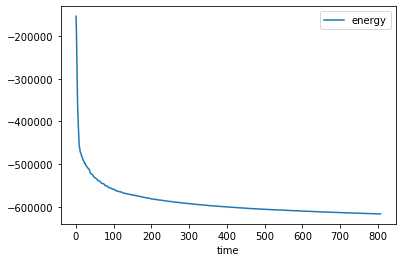

In [35]:
import pandas as pd
df = pd.read_csv('potential.xvg', sep='\s+', header=None, names=['time','energy'])
df.plot('time')

In alternative you can plot data file using Xmgrace plotting tool by directly output xvg format from the analysis tools. To use xmgrace from this notebook, remove the comment character (#) in the following cells: 

In [36]:
#!printf "Potential\n0\n" | gmx energy -f em.edr -o potential.xvg

To plot this data file, now you will need the Xmgrace plotting tool. 

In [37]:
#!xmgrace potential.xvg

Now that our system is at an energy minimum, we can begin real dynamics.

# Position restraints 

EM ensured that we have a reasonable starting structure, in terms of geometry and solvent orientation. To begin real dynamics, we must equilibrate the solvent and ions around the protein. If we were to attempt unrestrained dynamics at this point, the system may collapse. The reason is that the solvent is mostly optimized within itself, and not necessarily with the solute, and ions are randomly placed by replacing water molecules.

Remember that posre.itp file that pdb2gmx generated a long time ago? We're going to use it now. The purpose of posre.itp is to apply a position restraining force on the heavy atoms of the protein (anything that is not a hydrogen). Movement is permitted, but only after overcoming a substantial energy penalty. The utility of position restraints is that they allow us to relax our solvent and ions around our protein, without the added variable of structural changes in the protein. The origin of the position restraints (the coordinates at which the restraint potential is zero) is provided via a coordinate file passed to the -r option of grompp. Depending from the protein and ion types, this process may also be in the order nanoseconds.

To use position restraints we need to add \"define = -DPOSRES\" to the simulation parameter file, .mdp, (more details on the simulation parameters below). Have a look at the .mdp file for this run:

In [38]:
!head -5 input/nvt-charmm.mdp 

title                   = CHARMM NVT equilibration 
define                  = -DPOSRES  ; position restrain the protein

; Parameters describing what to do, when to stop and what to save
integrator              = md        ; leap-frog integrator


When using position restraints, a file with restraint coordinates must be supplied with -r to gmx grompp (see below). It can be the same file as supplied for -c. 

# Equilibration run - temperature

EM ensured that we have a reasonable starting structure, in terms of geometry and solvent orientation. Now the system needs to be brought to the temperature we wish to simulate and establish the proper orientation about the solute (the protein). After we arrive at the correct temperature (based on kinetic energies), we will apply pressure to the system until it reaches the proper density.

Equilibration is often conducted in two phases. The first phase is conducted under an NVT ensemble (constant Number of particles, Volume, and Temperature). This ensemble is also referred to as "isothermal-isochoric" or "canonical." The timeframe for such a procedure is dependent upon the contents of the system. Typically, 100-200 ps should suffice, and we will conduct a 100-ps NVT equilibration for this exercise. Depending on your machine, this may take a while (just under an hour if run in parallel on 16 cores or so).

We will call grompp and mdrun just as we did at the EM step, but this time with the energy minimised structure as input and a different .mdp file for the run. Have a look at the input file for this run:

In [39]:
!cat input/nvt-charmm.mdp

title                   = CHARMM NVT equilibration 
define                  = -DPOSRES  ; position restrain the protein

; Parameters describing what to do, when to stop and what to save
integrator              = md        ; leap-frog integrator
dt                      = 0.002     ; 2 fs
nsteps                  = 50000     ; 2 * 50000 = 100 ps
nstenergy               = 500       ; save energy and temperature every 1.0 ps

; periodic boundary condition
pbc                     = xyz       ;

; Keep system temperature fluctuating physically correct
tcoupl                  = V-rescale           ; modified Berendsen thermostat
tc-grps                 = system   ; coupling groups 
tau_t                   = 0.1      ; time constant, in ps
ref_t                   = 300      ; reference temperature, one for each group, in K

; Pressure coupling is off
pcoupl                  = no

; Velocity generation
gen_vel                 = yes                 ; assign velocities from Maxwell distribution
g

Instead of energy tolerance, we now give time a step size and a number of steps. Furthermore, we need to set a temperature. Now, we're good to run. Take note of a few parameters in the .mdp file:

- `gen_vel = yes`: Initiates velocity generation. Using different random seeds (gen_seed) gives different initial velocities, and thus multiple (different) simulations can be conducted from the same starting structure.
- `tcoupl = V-rescale`: The velocity rescaling thermostat is an improvement upon the Berendsen weak coupling method, which did not reproduce a correct kinetic ensemble.
- `pcoupl = no`: Pressure coupling is not applied. 

A full explanation of the parameters used can be found in the GROMACS [manual](http://manual.gromacs.org/documentation/current/user-guide/mdp-options.html), in addition to the comments provided. 

Now, we're good to run.

In [40]:
!gmx grompp -f input/nvt-charmm.mdp -c em.gro -r em.gro -p topol.top -o nvt.tpr 
!gmx mdrun -ntmpi 1 -v -deffnm nvt

                 :-) GROMACS - gmx grompp, 2022-conda_forge (-:

Executable:   /Users/ethan/anaconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/ethan/anaconda3/envs/md-intro-tutorial
Working dir:  /Users/ethan/md-intro-tutorial/md-intro-tutorial-main/data
Command line:
  gmx grompp -f input/nvt-charmm.mdp -c em.gro -r em.gro -p topol.top -o nvt.tpr

Ignoring obsolete mdp entry 'title'
Setting the LD random seed to -134291465

Generated 20503 of the 20503 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 1

Generated 17396 of the 20503 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_L'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'NA'

turning H bonds into constraints...

Excluding 1 bond

Your computer should be working at full speed now to finish this simulation; it should be done in 5 to 10 minutes. 

*Note: if you do not want to wait, but look at some of the results directly, copy the data from the /reference directory into the current directory. To do this from within this notebook, remove the comment characters (#) in the following cell*  

In [41]:
## ONLY execute the lines below if you do not want to run and wait for the simulation to finish
#!cp reference/nvt_charmm.edr nvt.edr
#!cp reference/nvt_charmm.gro nvt.gro
#!cp reference/nvt_charmm.cpt nvt.cpt

Let's analyze the temperature progression, again using gmx energy:

In [42]:
!echo "Temperature" | gmx energy -f nvt.edr -o temperature.xvg -xvg none

                 :-) GROMACS - gmx energy, 2022-conda_forge (-:

Executable:   /Users/ethan/anaconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/ethan/anaconda3/envs/md-intro-tutorial
Working dir:  /Users/ethan/md-intro-tutorial/md-intro-tutorial-main/data
Command line:
  gmx energy -f nvt.edr -o temperature.xvg -xvg none

Opened nvt.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  U-B              3  Proper-Dih.      4  Improper-Dih. 
  5  CMAP-Dih.        6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Coulomb-(SR)    10  Coul.-recip.    11  Position-Rest.  12  Potential     
 13  Kinetic-En.     14  Total-Energy    15  Conserved-En.   16  Temperature   
 17  Pressure        18  Constr.-rmsd    19  Vir-XX

<AxesSubplot:xlabel='time'>

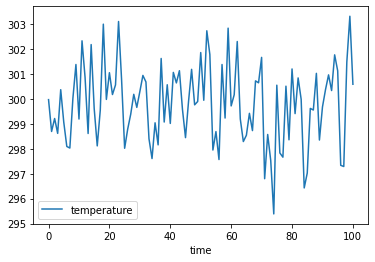

In [43]:
import pandas as pd
df = pd.read_csv('temperature.xvg', sep='\s+', header=None, names=['time','temperature'])
df.plot('time')

Or for alterantive visualization, remove the comment characters (#) in the following cells:

In [44]:
#!echo "Temperature" | gmx energy -f nvt.edr -o temperature.xvg

In [45]:
#!xmgrace temperature.xvg

From the plot, it is clear that the temperature of the system quickly reaches the target value (300 K), and remains stable over the remainder of the equilibration. For this system, an equilibration period (on the order of 50 ps) may be adequate.

# Equilibration run - pressure

The previous step, NVT equilibration, stabilized the temperature of the system. Prior to data collection, we must also stabilize the pressure (and thus also the density) of the system. Equilibration of pressure is conducted under an NPT ensemble, wherein the Number of particles, Pressure, and Temperature are all constant. The ensemble is also called the "isothermal-isobaric" ensemble, and most closely resembles experimental conditions.

The .mdp file used for a 100-ps NPT equilibration can be found here. It is not drastically different from the parameter file used for NVT equilibration. Note the addition of the pressure coupling section. Berendsen barostat is used for this equilibation phase.

In [46]:
!cat input/npt-charmm.mdp

title                   = CHARMM NPT equilibration 
define                  = -DPOSRES  ; position restrain the protein 

; Parameters describing what to do, when to stop and what to save
integrator              = md        ; leap-frog integrator
dt                      = 0.002     ; 2 fs
nsteps                  = 50000     ; 2 * 50000 = 100 ps
nstenergy               = 500       ; save energy and temperature every 1.0 ps

; periodic boundary condition
pbc                     = xyz       ;

continuation            = yes      

; Pressure coupling is on
pcoupl                  = C-rescale             ; Pressure coupling on in NPT
pcoupltype              = isotropic             ; uniform scaling of box vectors
tau_p                   = 1.0                   ; time constant, in ps
ref_p                   = 1.0                   ; reference pressure, in bar
compressibility         = 4.5e-5                ; isothermal compressibility of water, bar^-1
refcoord_scaling        = com

; Keep sy

A few other changes:

- `continuation = yes`: We are continuing the simulation from the NVT equilibration phase
- `gen_vel = no`: Velocities are read from the trajectory (see below) 

We will call grompp and mdrun just as we did for NVT equilibration. Note that we are now including the -t flag to include the checkpoint file from the NVT equilibration; this file contains all the necessary state variables to continue our simulation. To conserve the velocities produced during NVT, we must include the final coordinate file (output) of the NVT simulation using the option (-c).

In [47]:
!gmx grompp -f input/npt-charmm.mdp -c nvt.gro -r nvt.gro -t nvt.cpt -p topol.top -o npt.tpr

                 :-) GROMACS - gmx grompp, 2022-conda_forge (-:

Executable:   /Users/ethan/anaconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/ethan/anaconda3/envs/md-intro-tutorial
Working dir:  /Users/ethan/md-intro-tutorial/md-intro-tutorial-main/data
Command line:
  gmx grompp -f input/npt-charmm.mdp -c nvt.gro -r nvt.gro -t nvt.cpt -p topol.top -o npt.tpr

Ignoring obsolete mdp entry 'title'
Setting the LD random seed to -35422809

Generated 20503 of the 20503 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 1

Generated 17396 of the 20503 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_L'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'NA'

turning H bonds into constraints...

Excl

Now we'll start an MD simulation just like before - this one will take a few minutes; that's why it is commented out. Go ahead run it if you want to generate your own data.   

In [48]:
!gmx mdrun -ntmpi 1 -v -deffnm npt

                 :-) GROMACS - gmx mdrun, 2022-conda_forge (-:

Executable:   /Users/ethan/anaconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/ethan/anaconda3/envs/md-intro-tutorial
Working dir:  /Users/ethan/md-intro-tutorial/md-intro-tutorial-main/data
Command line:
  gmx mdrun -ntmpi 1 -v -deffnm npt

Reading file npt.tpr, VERSION 2022-conda_forge (single precision)
Changing nstlist from 10 to 80, rlist from 1.2 to 1.315

Using 1 MPI thread
Using 8 OpenMP threads 

starting mdrun 'COAGULATION FACTOR XA'
50000 steps,    100.0 ps.
step 49900, remaining wall clock time:     1 s          inish Wed Jun 22 10:09:30 2022
Writing final coordinates.
step 50000, remaining wall clock time:     0 s          
               Core t (s)   Wall t (s)        (%)
       Time:     6087.611      760.952      800.0
                 (ns/day)    (hour/ns)
Performance:       11.354        2.114

GROMACS reminds you: "Unlike teachers or doctors, our efforts improve the lives of people we'

If the simulation takes too long to run for this tutorial, you may use the provided data by copying it to the current directory. But remember that you can always check/analyse the output files while the simulation is still running. 

In [49]:
##ONLY execute the lines below if you do not want to run and wait for the simulation to finish
#!cp reference/npt_charmm.edr npt.edr
#!cp reference/npt_charmm.gro npt.gro
#!cp reference/npt_charmm.cpt npt.cpt

Let's analyze the pressure progression, again using energy:

In [50]:
!echo "Pressure" | gmx energy -f npt.edr -o pressure.xvg -xvg none

                 :-) GROMACS - gmx energy, 2022-conda_forge (-:

Executable:   /Users/ethan/anaconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/ethan/anaconda3/envs/md-intro-tutorial
Working dir:  /Users/ethan/md-intro-tutorial/md-intro-tutorial-main/data
Command line:
  gmx energy -f npt.edr -o pressure.xvg -xvg none

Opened npt.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  U-B              3  Proper-Dih.      4  Improper-Dih. 
  5  CMAP-Dih.        6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Coulomb-(SR)    10  Coul.-recip.    11  Position-Rest.  12  Potential     
 13  Kinetic-En.     14  Total-Energy    15  Conserved-En.   16  Temperature   
 17  Pressure        18  Constr.-rmsd    19  Box-X    

<AxesSubplot:xlabel='time'>

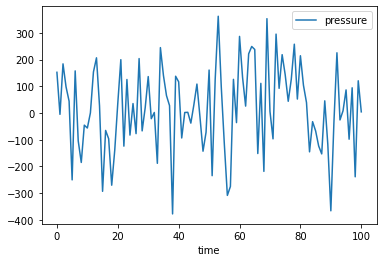

In [51]:
import pandas as pd
df = pd.read_csv('pressure.xvg', sep='\s+', header=None, names=['time','pressure'])
df.plot('time')

Or for alterantive visualization, remove the comment characters (#) in the following cells:

In [52]:
#!echo "Pressure" | gmx energy -f npt.edr -o pressure.xvg

In [53]:
#!xmgrace pressure.xvg

The pressure value fluctuates widely over the course of the 100-ps equilibration phase, but this behavior is not unexpected. The reference pressure was set to 1 bar, so is this outcome acceptable? Pressure is a quantity that fluctuates widely over the course of an MD simulation, as is clear from the large root-mean-square fluctuation (in the order of 100 bar), so statistically speaking, one cannot distinguish a difference between the obtained average and the target/reference value (1 bar). 

Let's take a look at density as well using energy.

In [54]:
!echo "Density" | gmx energy -f npt.edr -o density.xvg -xvg none

                 :-) GROMACS - gmx energy, 2022-conda_forge (-:

Executable:   /Users/ethan/anaconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/ethan/anaconda3/envs/md-intro-tutorial
Working dir:  /Users/ethan/md-intro-tutorial/md-intro-tutorial-main/data
Command line:
  gmx energy -f npt.edr -o density.xvg -xvg none

Opened npt.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  U-B              3  Proper-Dih.      4  Improper-Dih. 
  5  CMAP-Dih.        6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Coulomb-(SR)    10  Coul.-recip.    11  Position-Rest.  12  Potential     
 13  Kinetic-En.     14  Total-Energy    15  Conserved-En.   16  Temperature   
 17  Pressure        18  Constr.-rmsd    19  Box-X     

<AxesSubplot:xlabel='time'>

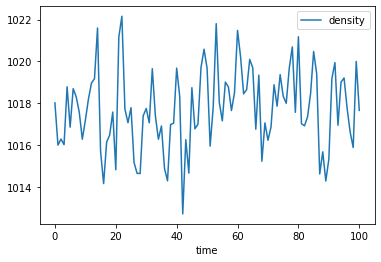

In [55]:
import pandas as pd
df = pd.read_csv('density.xvg', sep='\s+', header=None, names=['time','density'])
df.plot('time')

Or for alterantive visualization, remove the comment characters (#) in the following cells:

In [56]:
#!echo "Density" | gmx energy -f npt.edr -o density.xvg

In [57]:
#!xmgrace density.xvg

The average value is close to the experimental value of 1000 kg m-3 and the expected density of the TIP3P model of 1001 kg m-3. The parameters for the TIP3P water model closely replicate experimental values for water. The density values are very stable over time, indicating that the system is well-equilibrated now with respect to pressure and density.

Please note: Pressure-related terms are slow to converge, and thus you may have to run NPT equilibration slightly longer than is specified here.

# The "production" run

Upon completion of the two equilibration phases, the system is now well-equilibrated at the desired temperature and pressure. We are now ready to release the position restraints and run production MD for data collection. The process is just like we have seen before, as we will make use of the checkpoint file (which in this case now contains preserve pressure coupling information) to grompp. We will run a 1-ns MD simulation. We use velocity-rescaling temperature coupling as thermostat and stochastic cell rescaling as barostat. A full explanation of the available thermostats and barostats in GROMACS can be found in the manual (see [here](http://manual.gromacs.org/documentation/current/reference-manual/algorithms/molecular-dynamics.html#temperature-coupling) for thermostat and [here](http://manual.gromacs.org/documentation/current/reference-manual/algorithms/molecular-dynamics.html#pressure-coupling) for barostat)

In [58]:
!cat input/md-charmm.mdp

title                   = CHARMM NPT  

; Parameters describing what to do, when to stop and what to save
integrator              = md        ; leap-frog integrator
dt                      = 0.002     ; 2 fs
nsteps                  = 50000     ; 2 * 50000 = 100 ps

; periodic boundary condition
pbc                     = xyz       ;

continuation            = yes      

; Output control - output frequency in steps
; Output frequency for  output trajctory file ,trr
nstxout                  = 0       ; for writing coords (x) 
nstvout                  = 0       ; for writing velocities (v) 
nstfout                  = 0       ; for writing forces (f) 
; Output frequency for energies to log file and energy file
nstlog                   = 1000    ; for writing energies to log file
nstenergy                = 500     ; for writing energies to edr file 
; Output frequency and precision for .xtc file
nstxout-compressed       = 2500    ; for writing coords (x) 

; Pressure coupling is on
pcoupl   

Note we have explictly add a section that controls the output frequency in log file (.log), energy file (.edr), in the trajcotry file (.trr) and the compress trajectory file (.xtc).

gmx grompp will print an estimate for generated data and PME load. PME load will dictate how many processors should be dedicated to the PME calculation, and how many for the PP (everything except for PME) calculations. Refer to the [manual](http://manual.gromacs.org/documentation/current/user-guide/mdrun-performance.html#parallelization-schemes) for details.

In [59]:
!gmx grompp -f input/md-charmm.mdp -c npt.gro -t npt.cpt -p topol.top -o md.tpr

                 :-) GROMACS - gmx grompp, 2022-conda_forge (-:

Executable:   /Users/ethan/anaconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/ethan/anaconda3/envs/md-intro-tutorial
Working dir:  /Users/ethan/md-intro-tutorial/md-intro-tutorial-main/data
Command line:
  gmx grompp -f input/md-charmm.mdp -c npt.gro -t npt.cpt -p topol.top -o md.tpr

Ignoring obsolete mdp entry 'title'
Setting the LD random seed to -285774371

Generated 20503 of the 20503 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 1

Generated 17396 of the 20503 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein_chain_A'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Protein_chain_L'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'NA'

turning H bonds into constraints...

Excluding 1 bond

In [60]:
!gmx mdrun -ntmpi 1 -v -deffnm md

                 :-) GROMACS - gmx mdrun, 2022-conda_forge (-:

Executable:   /Users/ethan/anaconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/ethan/anaconda3/envs/md-intro-tutorial
Working dir:  /Users/ethan/md-intro-tutorial/md-intro-tutorial-main/data
Command line:
  gmx mdrun -ntmpi 1 -v -deffnm md

Reading file md.tpr, VERSION 2022-conda_forge (single precision)
Changing nstlist from 10 to 80, rlist from 1.2 to 1.315

Using 1 MPI thread
Using 8 OpenMP threads 

starting mdrun 'COAGULATION FACTOR XA'
50000 steps,    100.0 ps.
step 49900, remaining wall clock time:     1 s          
Writing final coordinates.
step 50000, remaining wall clock time:     0 s          
               Core t (s)   Wall t (s)        (%)
       Time:     5871.622      733.953      800.0
                 (ns/day)    (hour/ns)
Performance:       11.772        2.039

GROMACS reminds you: "If you know you are on the right track, if you have this inner knowledge, then nobody can turn you off.

As before, this run will take some time - probably more than planned for going through this tutorial. As an alternative, use the data provided here

In [61]:
##ONLY execute the lines below if you do not want to run and wait for the simulation to finish
#!cp reference/md_charmm.log md.log
#!cp reference/md_charmm.edr md.edr
#!cp reference/md_charmm.gro md.gro
#!cp reference/md_charmm.xtc md.xtc

# Analysis

Now that we have simulated our protein, we should run some analysis on the system. What types of data are important? This is an important question to ask before running the simulation, so you should have some ideas about the types of data you will want to collect in your own systems. For this tutorial, a few basic tools will be introduced.

The first tool is trjconv, which is used as a post-processing tool to strip out coordinates, correct for periodicity, or manually alter the trajectory (time units, frame frequency, etc). Here you find a suggested workflow for trjconv [link](https://manual.gromacs.org/2021/user-guide/terminology.html?highlight=periodic%20boundary). This exercise, we will use trjconv to account for any periodicity in the system. The protein will diffuse through the unit cell, and may appear "broken" or may "jump" across to the other side of the box. To account for such actions, issue the following:

In [62]:
!printf "1\n1\n" | gmx trjconv -s md.tpr -f md.xtc -o md_center.xtc -center -pbc mol

                :-) GROMACS - gmx trjconv, 2022-conda_forge (-:

Executable:   /Users/ethan/anaconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/ethan/anaconda3/envs/md-intro-tutorial
Working dir:  /Users/ethan/md-intro-tutorial/md-intro-tutorial-main/data
Command line:
  gmx trjconv -s md.tpr -f md.xtc -o md_center.xtc -center -pbc mol

Note that major changes are planned in future for trjconv, to improve usability and utility.
Will write xtc: Compressed trajectory (portable xdr format): xtc
Reading file md.tpr, VERSION 2022-conda_forge (single precision)
Reading file md.tpr, VERSION 2022-conda_forge (single precision)
Select group for centering
Group     0 (         System) has 39600 elements
Group     1 (        Protein) has  4417 elements
Group     2 (      Protein-H) has  2238 elements
Group     3 (        C-alpha) has   286 elements
Group     4 (       Backbone) has   858 elements
Group     5 (      MainChain) has  1142 elements
Group     6 (   MainChain+Cb) has

Select 1 ("Protein") as the group to be centered and 1 ("Protein") for output. We will conduct all our analyses on this "corrected" trajectory. Let's look at so obtained trajcetory using vmd. 

In [63]:
import nglview as ng 
import mdtraj as md
traj = md.load("md_center.xtc", top="1fjs_newbox.gro")
view = ng.show_mdtraj(traj)
view

NGLWidget(max_frame=20)

In alternative, remove the comment character (#) to use VMD 

In [64]:
#!vmd 1fjs_newbox.gro md_center.xtc

Note, the protein should never interact with its periodic image (minimum image convention), otherwise the forces calculated will be spurious. To calculate the distance between the protein and its periodic image, we use the tool mindist with the option -pi. 

In [65]:
!printf "1\n" | gmx mindist -s md.tpr -f md_center.xtc -pi -od mindist.xvg 
#!xmgrace mindist.xvg

                :-) GROMACS - gmx mindist, 2022-conda_forge (-:

Executable:   /Users/ethan/anaconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/ethan/anaconda3/envs/md-intro-tutorial
Working dir:  /Users/ethan/md-intro-tutorial/md-intro-tutorial-main/data
Command line:
  gmx mindist -s md.tpr -f md_center.xtc -pi -od mindist.xvg

Choose a group for distance calculation
Reading file md.tpr, VERSION 2022-conda_forge (single precision)
Reading file md.tpr, VERSION 2022-conda_forge (single precision)
Group     0 (         System) has 39600 elements
Group     1 (        Protein) has  4417 elements
Group     2 (      Protein-H) has  2238 elements
Group     3 (        C-alpha) has   286 elements
Group     4 (       Backbone) has   858 elements
Group     5 (      MainChain) has  1142 elements
Group     6 (   MainChain+Cb) has  1401 elements
Group     7 (    MainChain+H) has  1423 elements
Group     8 (      SideChain) has  2994 elements
Group     9 (    SideChain-H) has  109

The distance between the protein and its periodic image should not be smaller than the cut-off used to describe non-bonded interactions.

Now let's look at structural stability. GROMACS has a built-in utility for RMSD calculations called rms. To calculate RMSD relative to the crystal structure, issue this command:

In [66]:
!printf "4\n1\n" | gmx rms -s em.tpr -f md_center.xtc -o rmsd_xray.xvg -tu ns -xvg none

                  :-) GROMACS - gmx rms, 2022-conda_forge (-:

Executable:   /Users/ethan/anaconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/ethan/anaconda3/envs/md-intro-tutorial
Working dir:  /Users/ethan/md-intro-tutorial/md-intro-tutorial-main/data
Command line:
  gmx rms -s em.tpr -f md_center.xtc -o rmsd_xray.xvg -tu ns -xvg none

Reading file em.tpr, VERSION 2022-conda_forge (single precision)
Reading file em.tpr, VERSION 2022-conda_forge (single precision)
Select group for least squares fit
Group     0 (         System) has 39600 elements
Group     1 (        Protein) has  4417 elements
Group     2 (      Protein-H) has  2238 elements
Group     3 (        C-alpha) has   286 elements
Group     4 (       Backbone) has   858 elements
Group     5 (      MainChain) has  1142 elements
Group     6 (   MainChain+Cb) has  1401 elements
Group     7 (    MainChain+H) has  1423 elements
Group     8 (      SideChain) has  2994 elements
Group     9 (    SideChain-H) has  

Choose 4 ("Backbone") for both the least-squares fit and the group for RMSD calculation. The -tu flag will output the results in terms of ns, even though the trajectory was written in ps. This is done for clarity of the output (especially if you have a long simulation - 1ns does not look as nice as 100 ns). The output plot will show the RMSD relative to the structure present in the original pdb file:


<AxesSubplot:xlabel='time'>

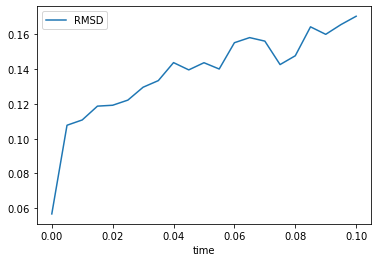

In [67]:
import pandas as pd
df = pd.read_csv('rmsd_xray.xvg', sep='\s+', header=None, names=['time','RMSD'])
df.plot('time')

Or for alterantive visualization, remove the comment characters (#) in the following cells:

In [68]:
#!printf "4\n1\n" | gmx rms -s em.tpr -f md_center.xtc -o rmsd_xray.xvg -tu ns

In [69]:
#!xmgrace rmsd_xray.xvg 

The time serie shows the RMSD levels off to ~0.15 nm (1 Å), indicating that the structure is stable. 

The option `-h` provides help information for GROMACS tool. 

In [70]:
!gmx rms -h

                  :-) GROMACS - gmx rms, 2022-conda_forge (-:

Executable:   /Users/ethan/anaconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/ethan/anaconda3/envs/md-intro-tutorial
Working dir:  /Users/ethan/md-intro-tutorial/md-intro-tutorial-main/data
Command line:
  gmx rms -h

SYNOPSIS

gmx rms [-s [<.tpr/.gro/...>]] [-f [<.xtc/.trr/...>]]
        [-f2 [<.xtc/.trr/...>]] [-n [<.ndx>]] [-o [<.xvg>]] [-mir [<.xvg>]]
        [-a [<.xvg>]] [-dist [<.xvg>]] [-m [<.xpm>]] [-bin [<.dat>]]
        [-bm [<.xpm>]] [-b <time>] [-e <time>] [-dt <time>] [-tu <enum>]
        [-[no]w] [-xvg <enum>] [-what <enum>] [-[no]pbc] [-fit <enum>]
        [-prev <int>] [-[no]split] [-skip <int>] [-skip2 <int>] [-max <real>]
        [-min <real>] [-bmax <real>] [-bmin <real>] [-[no]mw]
        [-nlevels <int>] [-ng <int>]

DESCRIPTION

gmx rms compares two structures by computing the root mean square deviation
(RMSD), the size-independent rho similarity parameter (rho) or the scaled rho
(

## Radius of gyration

The radius of gyration of a protein is a measure of its compactness. If a protein is stably folded, it will likely maintain a relatively steady value of Rg. If a protein unfolds, its Rg will change over time. Let's analyze the radius of gyration for the protein in our simulation:

In [71]:
!echo "1" | gmx gyrate -f md_center.xtc -s md.tpr -o gyrate.xvg -xvg none

                 :-) GROMACS - gmx gyrate, 2022-conda_forge (-:

Executable:   /Users/ethan/anaconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/ethan/anaconda3/envs/md-intro-tutorial
Working dir:  /Users/ethan/md-intro-tutorial/md-intro-tutorial-main/data
Command line:
  gmx gyrate -f md_center.xtc -s md.tpr -o gyrate.xvg -xvg none

Reading file md.tpr, VERSION 2022-conda_forge (single precision)
Reading file md.tpr, VERSION 2022-conda_forge (single precision)
Group     0 (         System) has 39600 elements
Group     1 (        Protein) has  4417 elements
Group     2 (      Protein-H) has  2238 elements
Group     3 (        C-alpha) has   286 elements
Group     4 (       Backbone) has   858 elements
Group     5 (      MainChain) has  1142 elements
Group     6 (   MainChain+Cb) has  1401 elements
Group     7 (    MainChain+H) has  1423 elements
Group     8 (      SideChain) has  2994 elements
Group     9 (    SideChain-H) has  1096 elements
Group    10 (    Prot-Mass

<AxesSubplot:xlabel='time'>

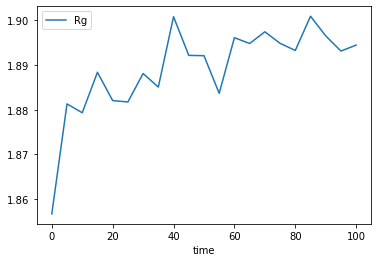

In [72]:
import pandas as pd
df = pd.read_csv('gyrate.xvg', sep='\s+', header=None, names=['time','Rg'], usecols=[0, 1])
df.plot('time')

Or for alterantive visualization, remove the comment characters (#) in the following cells:

In [73]:
#!echo "1" | gmx gyrate -f md_center.xtc -s md.tpr -o gyrate.xvg 

In [74]:
#!xmgrace gyrate.xvg

We can see from the reasonably invariant Rg values that the protein remains very stable, in its compact (folded) form over the course of 1 ns at 300 K. This result is not unexpected, but illustrates an advanced capacity of GROMACS analysis that comes built-in.

## Index file

Index groups are necessary for almost every GROMACS tools. All GROMACS tools can generate default index groups. If one needs special index groups, he/she can use gmx make_ndx to generate an index file (ndx). For example the command `splitch 1` splits the group 1 (Protein) in chains and the command `q`  close the tool.  

In [75]:
!printf "splitch 1\nq\n" | gmx make_ndx -f em.tpr -o 

                :-) GROMACS - gmx make_ndx, 2022-conda_forge (-:

Executable:   /Users/ethan/anaconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/ethan/anaconda3/envs/md-intro-tutorial
Working dir:  /Users/ethan/md-intro-tutorial/md-intro-tutorial-main/data
Command line:
  gmx make_ndx -f em.tpr -o


Reading structure file
Reading file em.tpr, VERSION 2022-conda_forge (single precision)
Reading file em.tpr, VERSION 2022-conda_forge (single precision)
Going to read 0 old index file(s)
Analysing residue names:
There are:   286    Protein residues
There are: 11703      Water residues
There are:    74        Ion residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...

  0 System              : 39600 atoms
  1 Protein             :  4417 atoms
  2 Protein-H           :  2238 atoms
  3 C-alpha             :   286 atoms
  4 Backbone            :   858 atoms
  5 MainChain           :  1142 atoms
  6 MainChain+Cb   

Now we can calculate the hydrogen bonds between the two protein chains using the tool gmx hbond. The option -num provide the number of hydrogen bond as a funtion of time.  

In [76]:
!printf "19\n20\n"| gmx hbond -f md.xtc -s md.tpr  -n index.ndx -num -xvg none

                 :-) GROMACS - gmx hbond, 2022-conda_forge (-:

Executable:   /Users/ethan/anaconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/ethan/anaconda3/envs/md-intro-tutorial
Working dir:  /Users/ethan/md-intro-tutorial/md-intro-tutorial-main/data
Command line:
  gmx hbond -f md.xtc -s md.tpr -n index.ndx -num -xvg none

Reading file md.tpr, VERSION 2022-conda_forge (single precision)
Specify 2 groups to analyze:
Group     0 (         System) has 39600 elements
Group     1 (        Protein) has  4417 elements
Group     2 (      Protein-H) has  2238 elements
Group     3 (        C-alpha) has   286 elements
Group     4 (       Backbone) has   858 elements
Group     5 (      MainChain) has  1142 elements
Group     6 (   MainChain+Cb) has  1401 elements
Group     7 (    MainChain+H) has  1423 elements
Group     8 (      SideChain) has  2994 elements
Group     9 (    SideChain-H) has  1096 elements
Group    10 (    Prot-Masses) has  4417 elements
Group    11 (    n

<AxesSubplot:xlabel='time'>

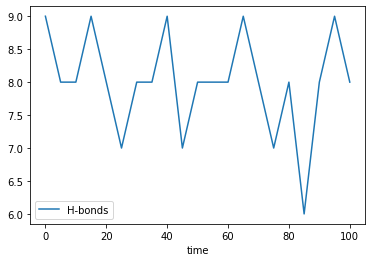

In [77]:
import pandas as pd
df = pd.read_csv('hbnum.xvg', sep='\s+', header=None, names=['time','H-bonds'], usecols=[0, 1])
df.plot('time')

Or for alterantive visualization, remove the comment characters (#) in the following cells:

In [78]:
#!printf "19\n20\n"| gmx hbond -f md.xtc -s md.tpr  -n index.ndx -num

In [79]:
#!xmgrace hbnum.xvg

## Excursion: Plotting gromacs data with "pandas" in python and notebooks

To analyse or visualize simulation data in python or jupyter notebooks, we can output a simplified xvg format from gmx-analysis tools with the option `-xvg none`

In [80]:
!echo "12\n0\n" | gmx energy -f em.edr -o potential.xvg -xvg none

                 :-) GROMACS - gmx energy, 2022-conda_forge (-:

Executable:   /Users/ethan/anaconda3/envs/md-intro-tutorial/bin.AVX2_256/gmx
Data prefix:  /Users/ethan/anaconda3/envs/md-intro-tutorial
Working dir:  /Users/ethan/md-intro-tutorial/md-intro-tutorial-main/data
Command line:
  gmx energy -f em.edr -o potential.xvg -xvg none

Opened em.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  U-B              3  Proper-Dih.      4  Improper-Dih. 
  5  CMAP-Dih.        6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Coulomb-(SR)    10  Coul.-recip.    11  Potential       12  Pressure      
 13  Constr.-rmsd    14  Vir-XX          15  Vir-XY          16  Vir-XZ        
 17  Vir-YX          18  Vir-YY          19  Vir-YZ    

And here is the plot..

<AxesSubplot:xlabel='time'>

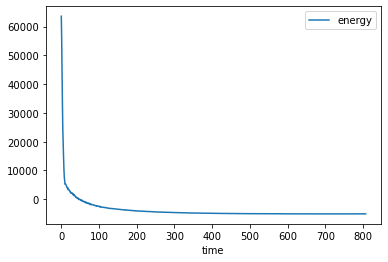

In [81]:
import pandas as pd
df = pd.read_csv('potential.xvg', sep='\s+', header=None, names=['time','energy'])
df.plot('time')